# Post Analysis of Rx and Rzz investigation data

Worksheet loads in the data for the Rx or Rzz investigation (error rate vs rotation angle), applies a first term Fourier series model to them of the form Error = B0 + B1sin(angle) + B2cos(angle) using regression, then plots the collected data along with the fitted model. 

Also provided in the plots are the parameters of the model and its F-value.

In [49]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from qiskit_ibm_runtime import QiskitRuntimeService
import TOKEN_DOC

## General Functions

In [50]:
def get_angle_mean_std(data_df):
    """get means and std for each rotation angle (repeat)"""
    # initialise arrays
    err_rate_means = []
    err_rate_stds = []
    rotation_angles  = []
    # loop thru rotation angles and find entries at that angle to mean and std
    for angle in data_df["angle"].unique():
        err_rates_single_angle = data_df.loc[data_df["angle"] == angle,"error_rate"].values
        err_rate_means.append(np.mean(err_rates_single_angle))
        err_rate_stds.append(np.std(err_rates_single_angle))
        rotation_angles.append(angle)
    
    return rotation_angles, err_rate_means, err_rate_stds

### Model fitting functions, not used

In [51]:
def fit_model(data_df):
    # 2. Build predictors
    data_df["sin_angle"] = np.sin(data_df["angle"])
    data_df["cos_angle"] = np.cos(data_df["angle"])

    X = data_df[["sin_angle", "cos_angle"]]
    X = sm.add_constant(X)
    y = data_df["error_rate"]

    # 3. Fit the regression model
    model = sm.OLS(y, X).fit()

    return model

In [52]:
ANGLE_RANGE = np.pi
angle_fine = np.linspace(0, ANGLE_RANGE, 500)
np.random.seed(42)  # for reproducibility

def get_model_predictions(model):
    # predict over fine angle grid
    sin_fine = np.sin(angle_fine)
    cos_fine = np.cos(angle_fine)

    # make x and y predictions for plotting
    X_pred = np.column_stack((np.ones_like(angle_fine), sin_fine, cos_fine))
    y_pred = X_pred @ model.params.values  # predicted mean

    return X_pred, y_pred

def do_bootstrap_conf_int(data_df, X_pred):
    # do some bootstrapping to give confidence intervals to 
    # model predictions
    n_bootstrap = 1000
    y_bootstrap = np.zeros((n_bootstrap, len(angle_fine)))

    for i in range(n_bootstrap):
        sample = data_df.sample(frac=1, replace=True)
        X_sample = sm.add_constant(sample[["sin_angle", "cos_angle"]])
        y_sample = sample["error_rate"]
        model_sample = sm.OLS(y_sample, X_sample).fit()
        params_sample = model_sample.params
        y_bootstrap[i] = X_pred @ params_sample.values

    lower_bound = np.percentile(y_bootstrap, 5, axis=0)
    upper_bound = np.percentile(y_bootstrap, 95, axis=0)

    return lower_bound, upper_bound

In [53]:
def fit_and_single_plot(data_df, y_pred, model, lower_bound, upper_bound):
    """Does a single term fourier series fit and then plots this with bootstaps
    not currently used"""
    # single plot for Rx
    # can I generalise this for Rzz? is it even worth it? 
    # maybe I just make sure they share the same options

    beta_0 = model.params["const"]
    beta_1 = model.params["sin_angle"]
    beta_2 = model.params["cos_angle"]

    fig, ax = plt.subplots()
    ax.figure(figsize=(12, 7))

    # Raw data points
    ax.scatter(data_df["angle"], data_df["error_rate"], color="blue", alpha=0.5, label="Data")

    # Fitted curve
    ax.plot(angle_fine, y_pred, color="red", lw=2, 
    # label=f"Fit: B₁={beta_1:.2f} (p={p_beta_1:.3g}), B₂={beta_2:.2f} (p={p_beta_2:.3g})")
    label=f"Fit: B₁={beta_1:.2f}, B₂={beta_2:.2f}")

    # Confidence bands
    ax.fill_between(angle_fine, lower_bound, upper_bound, color="red", alpha=0.2, label="95% CI (bootstrap)")

    ax.xlabel("Angle θ (radians)", fontsize=14)
    ax.ylabel("Error Rate", fontsize=14)
    ax.title(f"Error Rate vs Angle\nOverall Model F={f_stat:.2f}, p={f_pvalue:.3g}", fontsize=16)
    ax.xticks(np.linspace(0, 2*np.pi, 9), 
              ["0", "π/4", "π/2", "3π/4", "π", "5π/4", "3π/2", "7π/4", "2π"], fontsize=12)
    ax.yticks(fontsize=12)
    ax.grid(True, linestyle="--", alpha=0.7)
    ax.legend(fontsize=12)
    ax.tight_layout()
    ax.show()

## Rx
Load in csv generated by error_rx_by_angle.ipynb and plots it

### Fns

In [65]:
def single_plot(rotation_angles, means, stds, save_loc):
    """single plot graph, got smoe rx assumptions (axis labels)"""
    
    # do plot
    fig, ax = plt.subplots()
    plt.figure(figsize=(8, 5))
    # normalise angle by pi
    ax.errorbar(np.array(rotation_angles)/np.pi, 
                means, 
                yerr=stds,
                marker="o", linestyle="-", color="r")
    # rx label assumptions
    ax.set_xlabel(r"Rotation Angle / π (rad/π)")
    ax.set_ylabel("E_rel")
    ax.set_title("Error Rate by rotation angle of Rx Gate on IBM Noise Model")
    ax.grid()
    fig.savefig(save_loc, bbox_inches="tight")


### Stuff happening

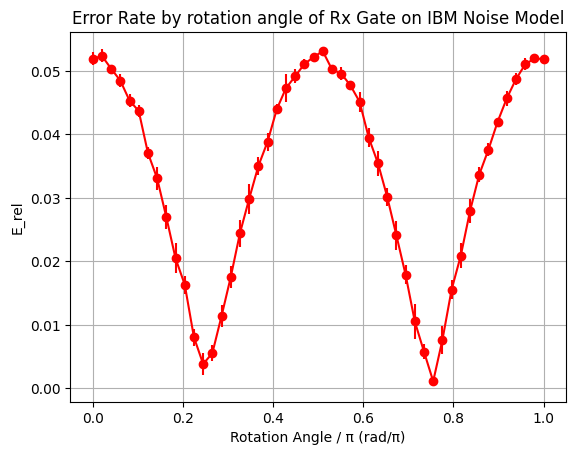

<Figure size 800x500 with 0 Axes>

In [66]:
# 1. Load the data
data = pd.read_csv("data/2_processed/rx_investigation_results.csv")

# 2. Fit model
# model = fit_model(data)
rotation_angles, err_rate_means, err_rate_stds = get_angle_mean_std(data)

# 3. Plot
save_loc = "plots/rx_error_rotation_angle.png"
single_plot(rotation_angles, err_rate_means, err_rate_stds, save_loc)


## Rzz
Bit more complex because data gets loaded from IBM servers

### Functions

In [56]:
# Loading in from IBM servers
# Has to be done in a few ways 
    # early work done without using batch
    # later work uses batch method

single_job_ids_fname = "data/1_interim/rzz_job_ids_1.csv"
batch_ids_fname = "data/1_interim/rzz_batch_ids.csv"
poss_outcomes = ["00", "01", "10", "11"]

In [57]:
#### Start with single batch #######
# have to use that this was the order the rotations were done in
# not great practice, future work has this embedded
gamma_values = np.pi*np.linspace(0, 1, 20)

def split_results_by_outcome(results, results_dict, gamma_val, repeats):
    """splits results by each possible outcome bitstring"""
    
    # all equally likely, so just divide shots by 4
    expected_num = results[0].data.meas.num_shots / 4
    
    # loop thru 00, 01, 10, 11
    for outcome in poss_outcomes:
        # get results for this outcome
        outcome_num = results[0].data.meas.get_counts().get(outcome, 0)
        # find change from expected
        outcome_diff = (outcome_num - expected_num) / expected_num
        # small conversions so things line up later
        gamma_rounded = float(gamma_val)
        # add to a dict containing info
        # this gets turned into a df later
        # dict is weird format - legacy of how earlier code was written
        results_dict[outcome]["gamma"].append(gamma_rounded)
        results_dict[outcome][f"rep{repeats}"].append(outcome_diff)
        
    return results_dict

# some strange formatting which gets undone later - legacy of path here
# details to allow it to run later
# replace token string with yours
service = QiskitRuntimeService(channel="ibm_quantum",
                               token=TOKEN_DOC.TOKEN_STRING)
repeat_num = 1
name_per_outc = ["gamma"] + [f"rep{rep_num}" for rep_num in range(repeat_num)]

def process_batch_results(ids:list[str], repeat_num=1):
    """from list of job id strings get the results from ibm
    server and put them into a dict to be plotted
    has to load in each job single - very inefficient"""
    count = 0
    results_dict = {outcome: {name : [] for name in name_per_outc} for outcome in poss_outcomes}
    for repeats in range(repeat_num):
        for gamma_val in gamma_values:      
            # expect them all with equal probability
            # produce error plots for each possibility
            results = service.job(job_id=ids[count]).result()
            count += 1
            results_dict = split_results_by_outcome(results, 
                                                    results_dict, 
                                                    gamma_val, 
                                                    repeats)
                                                    
    return results_dict

# now we can actually turn it into dataframe 
def single_runs_dict2df(results_dict):
    """dataframe more useful than dict, transform dict to df
    also does conversion of rotation angle = 2*gamma"""
    data = []
    for result_type, values in results_dict.items():
        for gamma, value in zip(values["gamma"], values["rep0"]):
            data.append({"result_type": result_type, 
                         "rotation_angle": 2*gamma, # angle is 2*gamma
                         "error_rate": value,
                        "repeat": 0})

    # Create the dataframe
    df_0 = pd.DataFrame(data)
    return df_0


def load_single_jobs():
    # load in single job ids
    single_job_ids_df = pd.read_csv(single_job_ids_fname, header=None)
    single_job_ids = single_job_ids_df.iloc[:,0].values
    # make a results dictionary based on this
    results_dict = process_batch_results(ids=single_job_ids,
                                         repeat_num=repeat_num)
    # turn this into a dataframe
    results_df = single_runs_dict2df(results_dict)
    return results_df

In [58]:
###### Now loading in batch ######
batch_job_ids_fname = "data/1_interim/rzz_batch_ids.csv"

def extract_dataframe_from_results(batch_id, repeat_num):
    """
    Extracts a DataFrame with columns: result_type, gamma, value
    from the fetched batch results object.
    """
    data = []
    # load in from ibm
    raw_results = service.job(job_id=batch_id).result()

    # Iterate through the results in raw_results
    for result in raw_results:
        gamma = result.metadata['circuit_metadata']['gamma']
        for result_type, value in result.data.meas.get_counts().items():
            expected_result = (raw_results[0].data.meas.num_shots / 4)
            frac_off = (value - expected_result) / expected_result
            data.append({
                'result_type': result_type,
                'rotation_angle': 2*gamma, # angle is 2*gamma
                'error_rate': frac_off,
                'repeat': repeat_num
            })
    
    # Create a DataFrame from the extracted data
    df = pd.DataFrame(data)
    return df

def load_batch_jobs():
    # load in batch job ids
    batch_job_ids_df = pd.read_csv(batch_job_ids_fname)
    # know this is the order
    repeat_nums = [1, 2, 2]
    # loop thru and get data in df format for all, then concat
    for i, id in enumerate(batch_job_ids_df["id"].values):
        results_df = extract_dataframe_from_results(batch_id=id,
                                                    repeat_num=repeat_nums[i])
        if i == 0:
            result_df_all = results_df.copy()
        else:
            result_df_all = pd.concat([result_df_all, results_df], 
                                      axis=0)
    return result_df_all

In [63]:
def multi_subplot(df_all_results, fname):
    """Designed for rzz 
    Plots subplots for each result_type from the DataFrame df_all_results.
    Each subplot has gamma on the x-axis and the average value on the y-axis,
    with error bars representing the standard deviation over repeats.
    """
    # Reset the index to work with grouped data
    df_reset = df_all_results.reset_index()

    # Group by result_type and gamma, and calculate mean and standard deviation
    grouped = df_reset.groupby(["result_type", "rotation_angle"]).agg(
        mean_value=("error_rate", "mean"),
        std_value=("error_rate", "std")
    ).reset_index()

    # Get unique result_types for subplots
    result_types = grouped["result_type"].unique()

    # Create subplots
    fig, axes = plt.subplots(2,2, 
                             figsize=(16, 10))

    clrs = ["b", "r", "g", "m"]

    # Plot for each result_type
    for i, (ax, result_type) in enumerate(zip(axes.flatten(), result_types)):
        # Filter data for the current result_type
        data = grouped[grouped["result_type"] == result_type]

        # Plot with error bars
        # normalise angle by pi
        ax.errorbar(
            data["rotation_angle"]/np.pi, data["mean_value"], yerr=data["std_value"]/2,
            fmt='o-', capsize=5, label=result_type,
            color=clrs[i]
        )

        # Set labels and title
        if len(str(result_type)) == 1:
            result_type = "0" + str(result_type)
        ax.set_title(f"Output: {result_type}")
        ax.grid("on")
        ax.set_xlabel(r"Rotation Angle / π (rad/π)")  
        ax.set_ylabel("E_rel")
        ax.set_ylim([-0.08, 0.08])

        ax.plot([min(ax.get_xlim()), max(ax.get_xlim())], 
                [0, 0], color="k", linewidth=1.5)
        ax.set_xlim([-0.025, 2.05])


    # Adjust layout
    plt.savefig(fname, bbox_inches="tight")

### Stuff happening

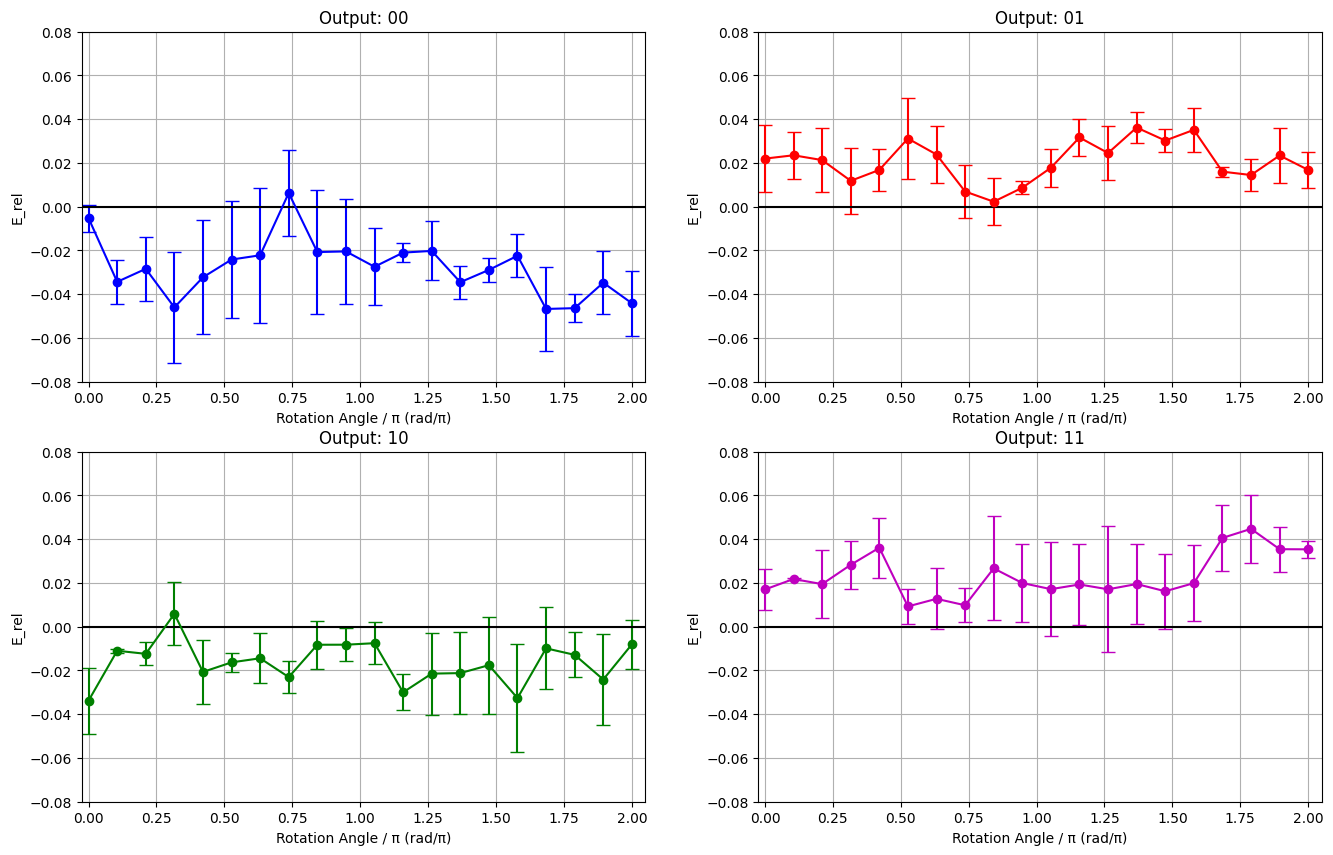

In [64]:
# 1. Load the data from IBM source
load_from_IBM = False
data_rzz_fname = "data/2_processed/rzz_investigation_results.csv"
if load_from_IBM:
    # load from IBM
    # talks to servers so can take a sec and needs internet
    data_single_job = load_single_jobs()
    data_batch_job = load_batch_jobs()
    data = pd.concat([data_single_job, data_batch_job],
                         axis=0)
    data.to_csv(data_rzz_fname)
else:
    # just load it in locally
    data = pd.read_csv(data_rzz_fname)

# 2. plot
# rzz bit less modular, plotting fn does averaging as well
multi_subplot(data, fname="plots/rzz_error_rotation_angle.png")